# SegmentNet
* Using x, y model parameters for segment instead of weight and bias
* initialization of parameters is key to faster training
* Best loss for this model with 4 segments is 0.095 in just 24 epocs. model.v4 with weights & bias as parameters has lowest loss of 0.03 but in 20,000 epocs

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Functions we are trying to approximate

In [5]:
np.random.seed(10)

# y = ax^4 + bx^3 + cx^2 + dx + f
def f_quarticn(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    x = x + 1
    return a*x**4 + b*x**3 + c*x**2 + d*x + f

def f_quartic(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    return a*x**4 + b*x**3 + c*x**2 + d*x + f
    
def f2_quartic(x):
    y = torch.zeros([2,x.shape[0]])
    y[0] = f_quartic(x)
    y[1] = f_quartic(x+1)
    return y

def f_inv_quartic(x):
    return 7 - f_quartic(x)
    
def f_semicircle(x):
    maxX = x.max()
    minX = x.min()
    radius = (maxX - minX)/2 
    center = (maxX + minX)/2 
    y = np.sqrt(np.abs(radius**2 - (x-center)**2))
    return y
    
def frand(y):
    return y + y*np.random.uniform(-0.1, 0.1, y.shape).astype('f')

def normalize(x,y):
    mu_x = torch.mean(x)
    std_x = torch.std(x)

    mu_y = torch.mean(y)
    std_y = torch.std(y)

    x_normalized = torch.nn.functional.normalize(x - mu_x, dim=0)
    y_normalized = torch.nn.functional.normalize(y - mu_y, dim=0)
    return x_normalized, y_normalized

## Visualize functions

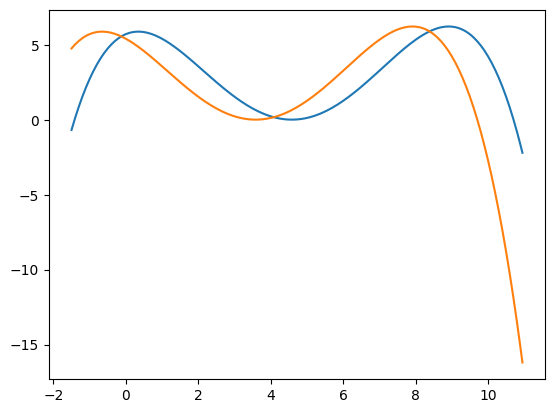

In [6]:
xs = torch.arange(-1.5, 11., .05)
ys = f2_quartic(xs)
plt.plot(xs, ys[0])
plt.plot(xs, ys[1])
plt.show()

# Model definition

## model test dev

In [7]:
# Test - how to initialize 2D x array with same values 
segment_features = 6
out_features = 1
x_init = torch.arange(0, 1 + 1./segment_features, 1./segment_features)
# make sure x_init shape is segment + 1 as it can be more for some segment_features like 6
x_init = x_init[0:1+segment_features]
x_2dinit = torch.Tensor(out_features, segment_features + 1)
x_2dinit[:] = x_init.unsqueeze(0)
x = torch.Tensor(x_2dinit)
print(x.shape, x_init.unsqueeze(0).shape)
# slightly modify second row
if(out_features > 1):
    x[1, 1:-1] = x[1, 1:-1] + .1
print(x)

torch.Size([1, 7]) torch.Size([1, 7])
tensor([[0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000]])


In [8]:
x_in = np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9])
x_in = torch.tensor(x_in.reshape(x_in.shape[0],1), dtype=torch.float32)
x_in.shape

torch.Size([9, 1])

In [9]:
#forward
lt = torch.lt(x_in.unsqueeze(1).unsqueeze(1), x[:, 1:]) 
ge = torch.ge(x_in.unsqueeze(1).unsqueeze(1), x[:, :-1]) 
mask = (lt & ge)
#print(mask)
y = torch.Tensor(out_features, segment_features + 1)
#y = copy(x)
if(out_features > 1):
    y[0,:] = x[0, :]
    y[1,:] = x[1,:]*2
else:
    y[0,:] = x[0, :]
print ("x=",x)
print("y=",y)
ratio = (y[:,1:]-y[:,:-1])/(x[:,1:]-x[:,:-1])
print("ratio=",ratio)
y_pred = (x_in.unsqueeze(1).unsqueeze(1) -  x[:,:-1])*mask*ratio + mask * y[:,:-1]
print(y_pred.shape, y_pred.sum(dim=3).squeeze(2).shape)
print("ypred=",y_pred.sum(dim=3).squeeze(2))

x= tensor([[0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000]])
y= tensor([[0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000]])
ratio= tensor([[1., 1., 1., 1., 1., 1.]])
torch.Size([9, 1, 1, 6]) torch.Size([9, 1])
ypred= tensor([[0.1000],
        [0.2000],
        [0.3000],
        [0.4000],
        [0.5000],
        [0.6000],
        [0.7000],
        [0.8000],
        [0.9000]])


## Model 

In [ ]:
#Code modified for x,y parameters

class TwoDSegmentNet(nn.Module):
    def __init__(self, out_features, segment_features):
        super(TwoDSegmentNet, self).__init__()
        self.segment_features = segment_features
        self.out_features = out_features
        
        #Initialize x coordinates between 0-1 so segments are equal size
        x_init = torch.arange(0, 1 + 1./segment_features, 1/segment_features)
        # make sure x_init shape is segment + 1 as it can be more for some segment_features like 6
        x_init = x_init[0:1+segment_features]
        # make a 2D init tensor
        x_2dinit = torch.Tensor(out_features, segment_features + 1)
        # Update the x_2dinit tensor with the repeated values
        x_2dinit[:] = x_init.unsqueeze(0)
        # initialize all rows of x
        self.x = nn.Parameter(torch.Tensor(x_2dinit))
        #print(self.x.shape)
        #y can be zeros
        self.y = nn.Parameter(torch.Tensor(out_features, segment_features + 1))
        
    
    def forward(self, x_in):
        #print("x_in.shape:",x_in.shape)        
        # to find out if x is between segments
        lt = torch.lt(x_in.unsqueeze(1).unsqueeze(1), self.x[:, 1:]) 
        ge = torch.ge(x_in.unsqueeze(1).unsqueeze(1), self.x[:, :-1]) 
        mask = (lt & ge)

        # Ratio is the segment (y2-y1)/(x2-x1) ratio 
        # consider each segment as a right triangle so we can find new y-y1 as ratio of x-x1
        ratio = (self.y[:,1:]-self.y[:,:-1])/(self.x[:,1:]-self.x[:,:-1])

        ypred = (x_in.unsqueeze(1).unsqueeze(1) -  self.x[:,:-1])*mask*ratio + mask * self.y[:,:-1]
        ypred = ypred.sum(dim=3).squeeze(2)
        #print("ypred.shape:",ypred.shape)
        return ypred
            
    def extra_repr(self) -> str:
        return f'out_features={self.out_features}, segment_features={self.segment_features}'

In [11]:
#Code modified for x,y parameters

class OneLayerSegmentNet(nn.Module):
    def __init__(self, out_features, segment_features):
        super(OneLayerSegmentNet, self).__init__()
        self.segment_features = segment_features
        self.out_features = out_features
        
        #Initialize x coordinates between 0-1 so segments are equal size
        x_init = torch.arange(0, 1 + 1./segment_features, 1/segment_features)
        # make sure x_init shape is segment + 1 as it can be more for some segment_features like 6
        x_init = x_init[0:1+segment_features]
        # make a 2D init tensor
        #x_2dinit = torch.Tensor(out_features, segment_features + 1)
        # Update the x_2dinit tensor with the repeated values
        #x_2dinit[:] = x_init.unsqueeze(0)
        # initialize all rows of x
        self.x = nn.Parameter(torch.Tensor(x_init))
        #y can be zeros
        self.y = nn.Parameter(torch.Tensor(segment_features + 1))
        #print("self.x.shape",self.x.shape)
        #print("self.y.shape",self.y.shape)
        
    
    def forward(self, x_in):
        #print("x_in.shape:",x_in.shape)        
        # to find out if x is between segments
        lt = torch.lt(x_in.unsqueeze(1), self.x[1:]) 
        ge = torch.ge(x_in.unsqueeze(1), self.x[:-1]) 
        mask = (lt & ge)
        #print("mask.shape:",mask.shape)
        #print("mask:", mask)

        # Ratio is the segment (y2-y1)/(x2-x1) ratio 
        # consider each segment as a right triangle so we can find new y-y1 as ratio of x-x1
        ratio = (self.y[1:]-self.y[:-1])/(self.x[1:]-self.x[:-1])
        #print("ratio:",ratio)

        ypred = (x_in.unsqueeze(1) -  self.x[:-1])*mask*ratio + mask * self.y[:-1]
        ypred = ypred.sum(dim=2)
        #print("ypred.shape:",ypred.shape)
        return ypred
            
    def extra_repr(self) -> str:
        return f'out_features={self.out_features}, segment_features={self.segment_features}'

# Data Loaders

In [12]:
from torch.utils.data.dataloader import DataLoader

class InfiniteRandomDataLoader:

    def __init__(self, dataset, loss, replacement=True, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=replacement, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch


## Model helper functions

In [13]:
def get_model_param_grad(model):
    dt = {}
    for param in model.parameters():
        if(param.shape == (model.segment_features,1)):
            dt['weight_grad'] = param.grad
        else:
            dt['bias_grad'] = param.grad
    return dt

# Model Training with random data loader

# Init

In [139]:
# init training
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

torch.manual_seed(10)

model = OneLayerSegmentNet(1, 4)
criterion = nn.MSELoss(reduction='sum')

# Capture params after initialization
model_params = []
#model_param_grads = []
model_params.append(copy.deepcopy(model.state_dict()))

#create ys data from scratch so we can sort xs as needed - made no different with randomloader for segmentnet
f = f_quartic # select data function
xs = np.arange(-1.5, 11., .05)
ys = f(xs)
#print(xs.shape, ys.shape)

x = torch.tensor((xs).reshape(xs.shape[0],1), dtype=torch.float32)
ytest = torch.tensor((ys).reshape(ys.shape[0],1), dtype=torch.float32) # y is from function / not randomized

#Test normalization - works
x, ytest = normalize(x, ytest)

#Initialize model parameters
model.x = torch.nn.Parameter(torch.Tensor(np.linspace(x.min(), x.max(), model.segment_features+1)))

dataLoader = InfiniteRandomDataLoader

# create dataset that can be used in a dataloader 
dataset = torch.utils.data.TensorDataset(x, ytest)

#initialize training params
step = 0
losses = np.array([])
with torch.no_grad():
    y = model(x)
    total_mean_loss = criterion(y, ytest)
#    losses = np.append(losses, total_mean_loss)

lr=.01
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=.75, patience=100,threshold=0.01, threshold_mode='rel', cooldown=0, 
                                                 min_lr=0, eps=1e-08, verbose=True) # let us try scheduler to reduce learning rate

## Training loop

In [140]:
# training loop

torch.manual_seed(10)

best_loss = .01
prev_total_mean_loss = 100
max_steps = 100

model.train() # We use this variable for training
# init dataloader
batch_loader = dataLoader(dataset,loss=total_mean_loss,replacement=False, batch_size=64, pin_memory=True, num_workers=1)

while True:
    t0 = time.time()
    # get the next batch, ship to device, and unpack it to input and target
    X, Y = batch_loader.next()
    #check for NaN
    if math.isnan(Y.mean()):
        print ("Breaking for NaN")
        break

    # Forward pass
    ypred = model(X)

    # Calculate the loss
    loss = criterion(ypred, Y)
    
    # Backward and optimize
    model.zero_grad(set_to_none=True)
    loss.backward()

    # Evaluate model after this optimizer.step
    # we evaluate on complete data
    with torch.no_grad():
        y = model(x)
        total_mean_loss = criterion(y, ytest)
    losses = np.append(losses, total_mean_loss)

    optimizer.step() #Definitely needed
    step += 1
    scheduler.step(total_mean_loss)
    t1 = time.time()

    # store params (weights and biases) after each training step
    if step % 1 == 0:
        model_params.append(copy.deepcopy(model.state_dict()))
        #model_param_grads.append(get_model_param_grad(model))
             
    # logging
    if step % 1 == 0:         
        print(f"step {step} | loss {loss:.4f} | total_mean_loss {total_mean_loss:.4f} | step time {(t1-t0)*1000:.2f}ms")

    # termination conditions
    if max_steps >= 0 and step % max_steps == 0:
        break
        
    #if total_mean_loss.mean() < best_loss:
        break

    #if total_mean_loss.mean() > prev_total_mean_loss*1.5:
    #    break #we may want to change learning rate

    prev_total_mean_loss = total_mean_loss

step 1 | loss 0.2834 | total_mean_loss 1.0000 | step time 782.02ms
step 2 | loss 0.2252 | total_mean_loss 0.8900 | step time 1.27ms
step 3 | loss 0.1810 | total_mean_loss 0.7305 | step time 0.66ms
step 4 | loss 0.1411 | total_mean_loss 0.6153 | step time 0.65ms
step 5 | loss 0.1297 | total_mean_loss 0.5485 | step time 0.63ms
step 6 | loss 0.1699 | total_mean_loss 0.5088 | step time 0.71ms
step 7 | loss 0.1253 | total_mean_loss 0.4314 | step time 0.65ms
step 8 | loss 0.0618 | total_mean_loss 0.3330 | step time 0.71ms
step 9 | loss 0.0738 | total_mean_loss 0.2438 | step time 0.63ms
step 10 | loss 0.0578 | total_mean_loss 0.2430 | step time 0.60ms
step 11 | loss 0.0516 | total_mean_loss 0.2657 | step time 0.57ms
step 12 | loss 0.0757 | total_mean_loss 0.2588 | step time 0.69ms
step 13 | loss 0.0685 | total_mean_loss 0.2037 | step time 0.59ms
step 14 | loss 0.0540 | total_mean_loss 0.1787 | step time 0.84ms
step 15 | loss 0.0287 | total_mean_loss 0.1864 | step time 0.86ms
step 16 | loss 0.

 prev_total_mean_loss  tensor(0.1616)


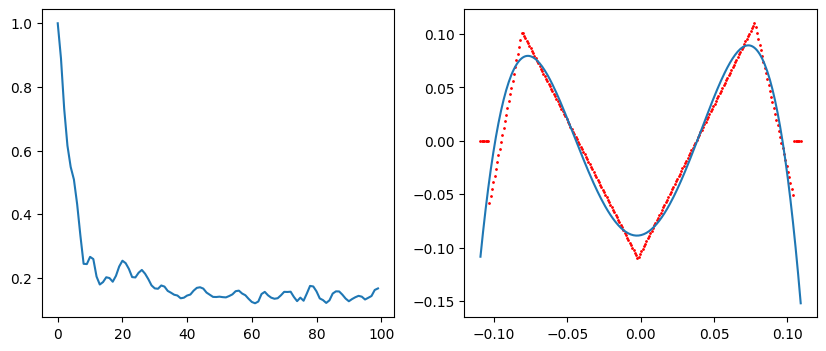

In [141]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 4) # this is done to increase width to 

# Create a figure and two axes objects
# Increase the figure size to accommodate wider plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot loss
print (" prev_total_mean_loss ",prev_total_mean_loss)
ax1.plot(losses)

# plot trained model
y = model(x)
yout = y.data.reshape(xs.shape[0])
ax2.plot(x, ytest)
ax2.scatter(x, yout, color='red', s=1)

# Display the plot
plt.show()

In [49]:
#!pip install torchviz
from torchviz import make_dot

# Generate a Graphviz object from the computation graph
graph = make_dot(loss, params=dict(model.named_parameters())) 

# Save the graph as a PDF or any other format if needed
#graph.render("model_segment_v5_graph")

'model_segment_v5_graph.pdf'

In [148]:
model_params[-10],model_params[-1],x.min(), x.max()

(OrderedDict([('x', tensor([-0.1080, -0.0823, -0.0040,  0.0775,  0.1041])),
              ('y', tensor([-0.0600,  0.1000, -0.1102,  0.1125, -0.0524]))]),
 OrderedDict([('x', tensor([-0.1038, -0.0808, -0.0019,  0.0777,  0.1042])),
              ('y', tensor([-0.0641,  0.1025, -0.1102,  0.1106, -0.0525]))]),
 tensor(-0.1091),
 tensor(0.1091))

In [168]:
model_params[-1]['x'].numpy()

array([-0.1038238 , -0.08080871, -0.00194593,  0.07774183,  0.10418735],
      dtype=float32)

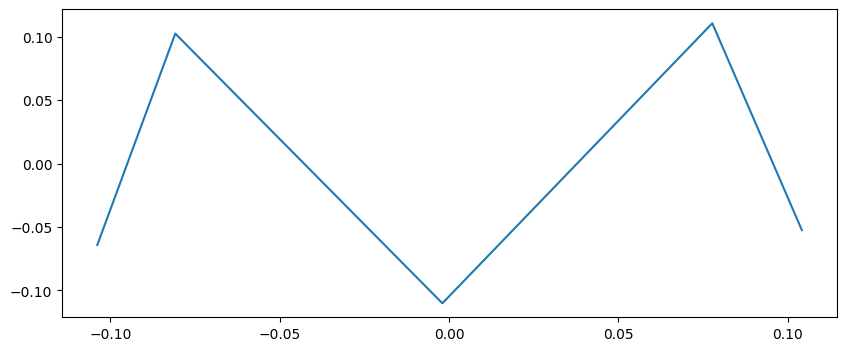

In [186]:
a = plt.plot(model_params[-1]['x'],model_params[-1]['y']) 

# Show training as animation

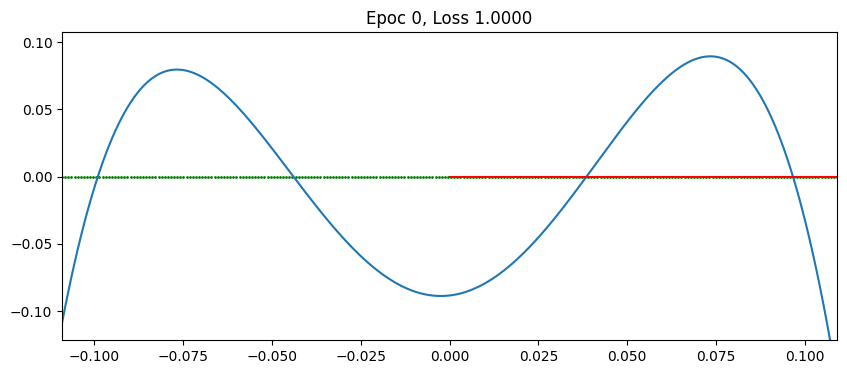

In [211]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_xlim(x.min(), x.max())
ax.set_ylim(ytest.min()*.8, ytest.max()*1.2)
ax.plot(x, ytest)
scatter = ax.scatter([], [], c='g',s=1)
a = ax.plot([], [], c='r', linestyle="-")

def animate(i):
    model.load_state_dict(model_params[i])
    px = model_params[i]['x']
    py = model_params[i]['y']
    a[0].set_data(px, py)

    #alternate plot
    with torch.no_grad():
        model.eval() # be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.
        y = model(x)
    yout = y.data.reshape(xs.shape[0])
    scatter.set_offsets(np.column_stack((x, yout)))
    ax.set_title(f"Epoc {i*1}, Loss {losses[1*(i)]:.4f}")
    return a

anim = FuncAnimation(fig, animate, frames=range(0,len(model_params)-1, 2))

In [212]:
from IPython.display import HTML
HTML(anim.to_jshtml())